### Import All Libraries

In [39]:
from idlelib.macosx import hideTkConsole

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from matplotlib.pyplot import clf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier


%matplotlib inline
plt.style.use('ggplot')

### Brief Data Check

*Notice that PCA transformation has been performed on the data to protect PII. It has resulted in 28 principal components

In [11]:
df = pd.read_csv('creditcard.csv')
df_copy = df.copy()
print(df.head(), df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Check for Missing Values

There are no missing values, so we will not have to deal with null values.

In [12]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


### Conduction of Elementary Exploratory Data Analysis

We will look at:
- Countplot
    - We notice that the dataset is HIGHLY imbalanced, with a very small percentage of the transactions being fraudulent
- Time of Transaction (entire dataset, non-fraudulent, fraudulent)

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

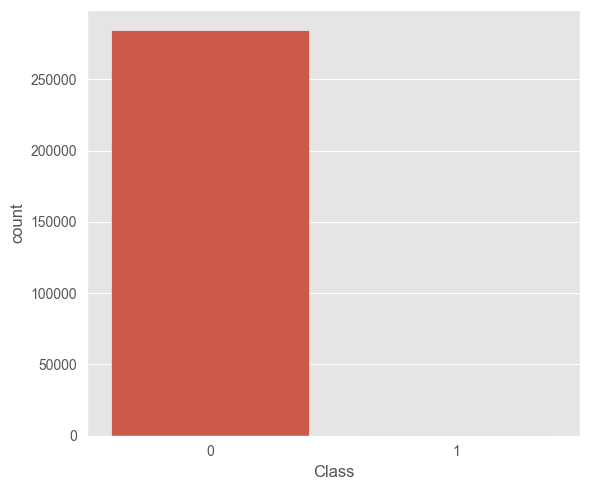

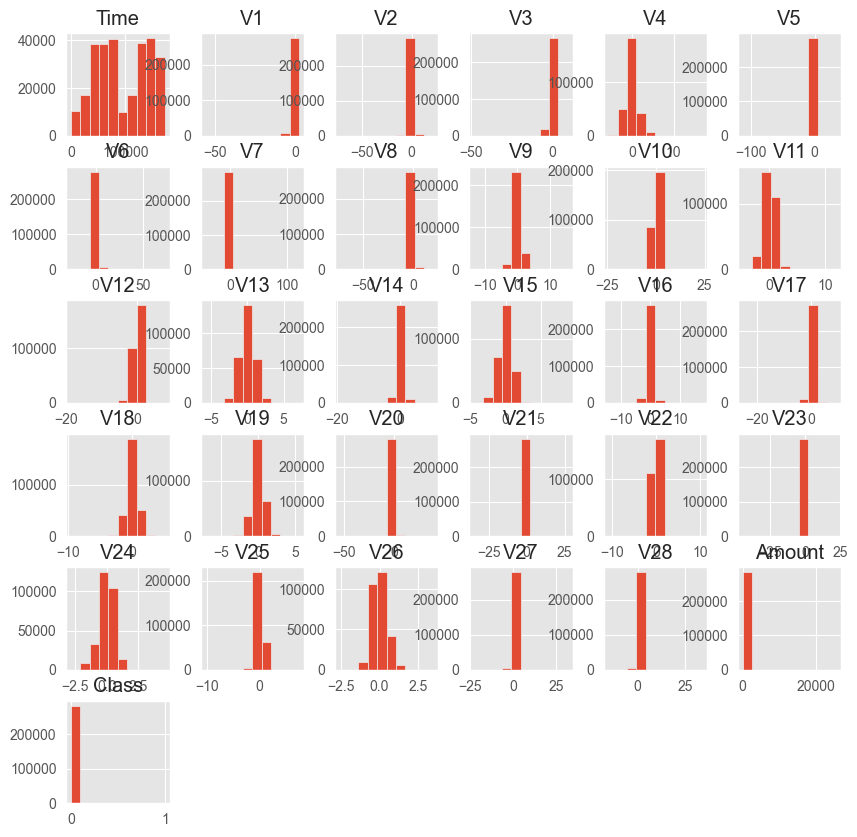

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.countplot(x = 'Class', data = df)
plt.tight_layout()
df.hist(figsize=(10, 10))

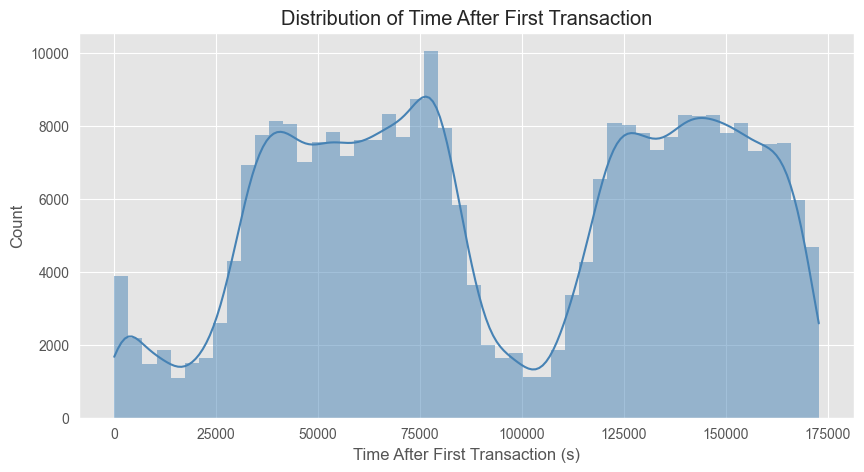

<Figure size 960x320 with 0 Axes>

In [14]:
df['Time'].describe()

# Time after first Transaction
df['Time_After_First_Transaction'] = df['Time'] - df['Time'].min()

fig, ax = plt.subplots(figsize=(10, 5))

plt.figure(figsize=(12, 4), dpi=80)
sns.histplot(
    df["Time_After_First_Transaction"],
    bins=50,
    kde=True,                 # add KDE curve
    stat="count",
    linewidth=0,
    color="steelblue",
    ax=ax
)
ax.set_title("Distribution of Time After First Transaction")
ax.set_xlabel("Time After First Transaction (s)")
ax.set_ylabel("Count")

plt.show()

Let's plot the time of transactions against the count. We are hoping to see a different trend with the fraudulent transactions. This is a good visual test.

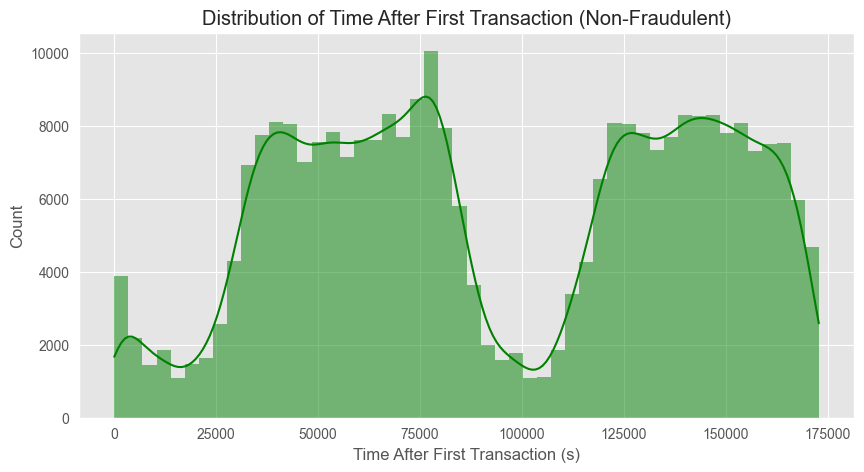

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    data=df[df["Class"] == 0],
    x="Time_After_First_Transaction",
    bins=50,
    stat="count",
    kde=True,
    linewidth=0,
    color="green",
    #alpha=0.6,
    label="Normal (0)",
    ax=ax
)
ax.set_title("Distribution of Time After First Transaction (Non-Fraudulent)")
ax.set_xlabel("Time After First Transaction (s)")
ax.set_ylabel("Count")

plt.show()

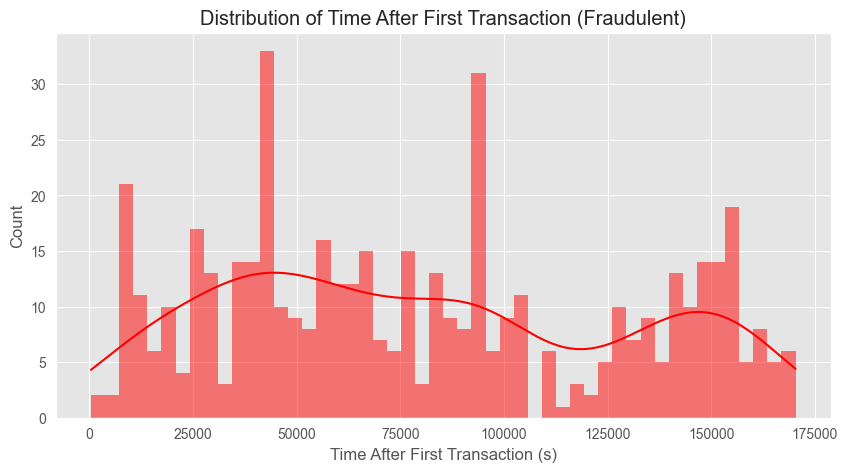

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

# Fraud (Class = 1)
sns.histplot(
    data=df[df["Class"] == 1],
    x="Time_After_First_Transaction",
    bins=50,
    stat="count",
    kde=True,
    linewidth=0,
    color="red",
    #alpha=0.6,
    label="Fraud (1)",
    ax=ax
)
ax.set_title("Distribution of Time After First Transaction (Fraudulent)")
ax.set_xlabel("Time After First Transaction (s)")
ax.set_ylabel("Count")

plt.show()

We will plot the fraudulent transactions on the same plot at the non-fraudulent transactions. We see that some of the fraudulent transactions are happening during the regular downtime of the non-fraudulent transactions.

\* We took the log of the count for the non-fraudulent transactions so that the values may be comparable.

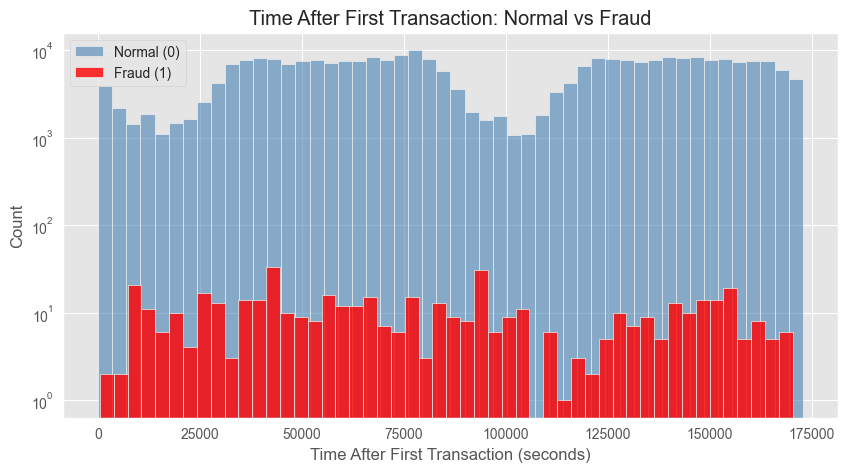

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

#1) Non‑fraud (Class = 0) as the background
sns.histplot(
    data=df[df["Class"] == 0],
    x="Time_After_First_Transaction",
    bins=50,
    stat="count",
    color="steelblue",
    alpha=0.6,
    label="Normal (0)",
    ax=ax
)

# 2) Fraud (Class = 1) layered on top
sns.histplot(
    data=df[df["Class"] == 1],
    x="Time_After_First_Transaction",
    bins=50,
    stat="count",
    color="red",
    alpha=0.8,
    label="Fraud (1)",
    ax=ax
)

ax.set_yscale('log')
#ax.set_ylim(0, 200)
ax.set_title("Time After First Transaction: Normal vs Fraud")
ax.set_xlabel("Time After First Transaction (seconds)")
ax.set_ylabel("Count")
ax.legend()

plt.show()

We have some outliers. Removing these outliers may remove some fraudulent transactions. Due to the low count of fraudulent transactions, we should not remove the already rare fraudulent transactions. We can see from boxplots that the distribution is extremely right skewed. We have a high number of outliers that will negatively impact our model.

<Axes: xlabel='Amount'>

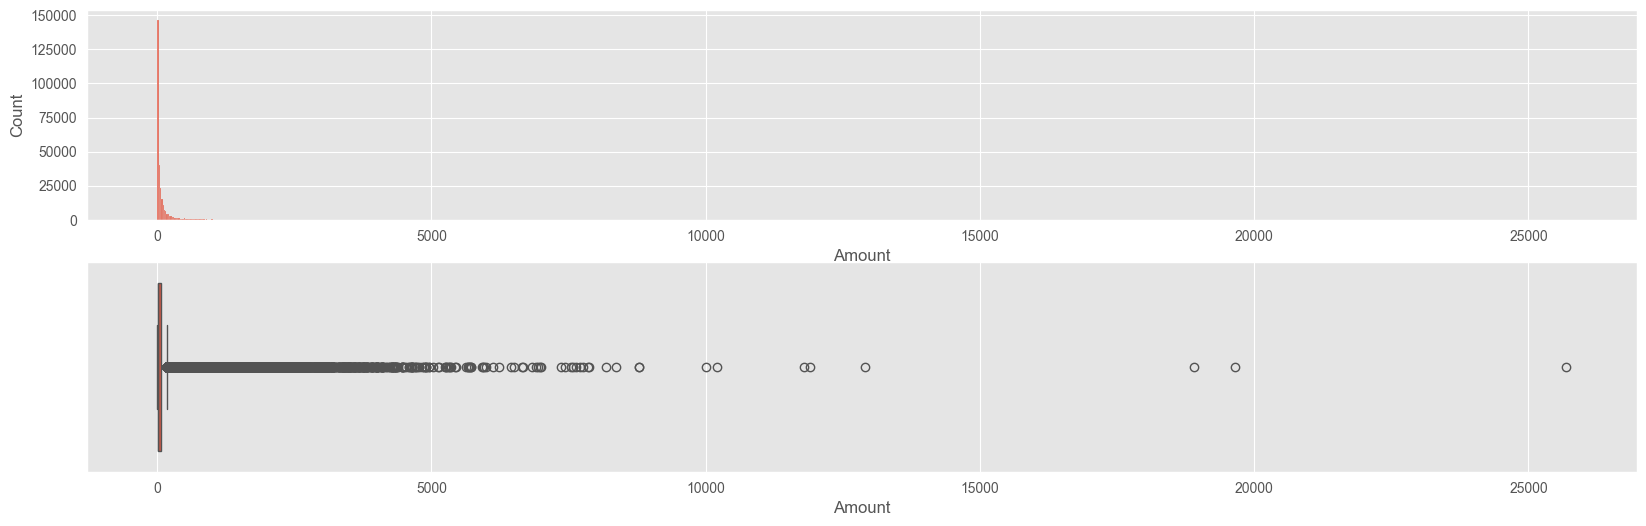

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20, 6))
sns.histplot(df_copy.Amount, ax=ax1)
sns.boxplot(df_copy.Amount, ax=ax2, orient = "h")

Using the Interquartile Range (IQR), a measure of statistical dispersion, we can use the points that fall outside the range to help us decide what outliers are appropriate to remove.

In [19]:
from scipy.stats import iqr
upper_limit_remove = df_copy.Amount.quantile(0.75) + (1.5 * iqr(df_copy.Amount))
print(upper_limit_remove)
print(df_copy[df_copy.Amount > upper_limit_remove]["Class"].value_counts())
print("-------")
df = df[df.Amount <=8000]
print(df['Class'].value_counts())
print('/nPercentage of fraudulent transactions: {:.2%}'.format((df[df['Class'] ==1].shape[0] / df.shape[0])))

184.5125
Class
0    31813
1       91
Name: count, dtype: int64
-------
Class
0    284303
1       492
Name: count, dtype: int64
/nPercentage of fraudulent transactions: 0.17%


Text(0.5, 1.0, 'Non-Fraudulent Transactions')

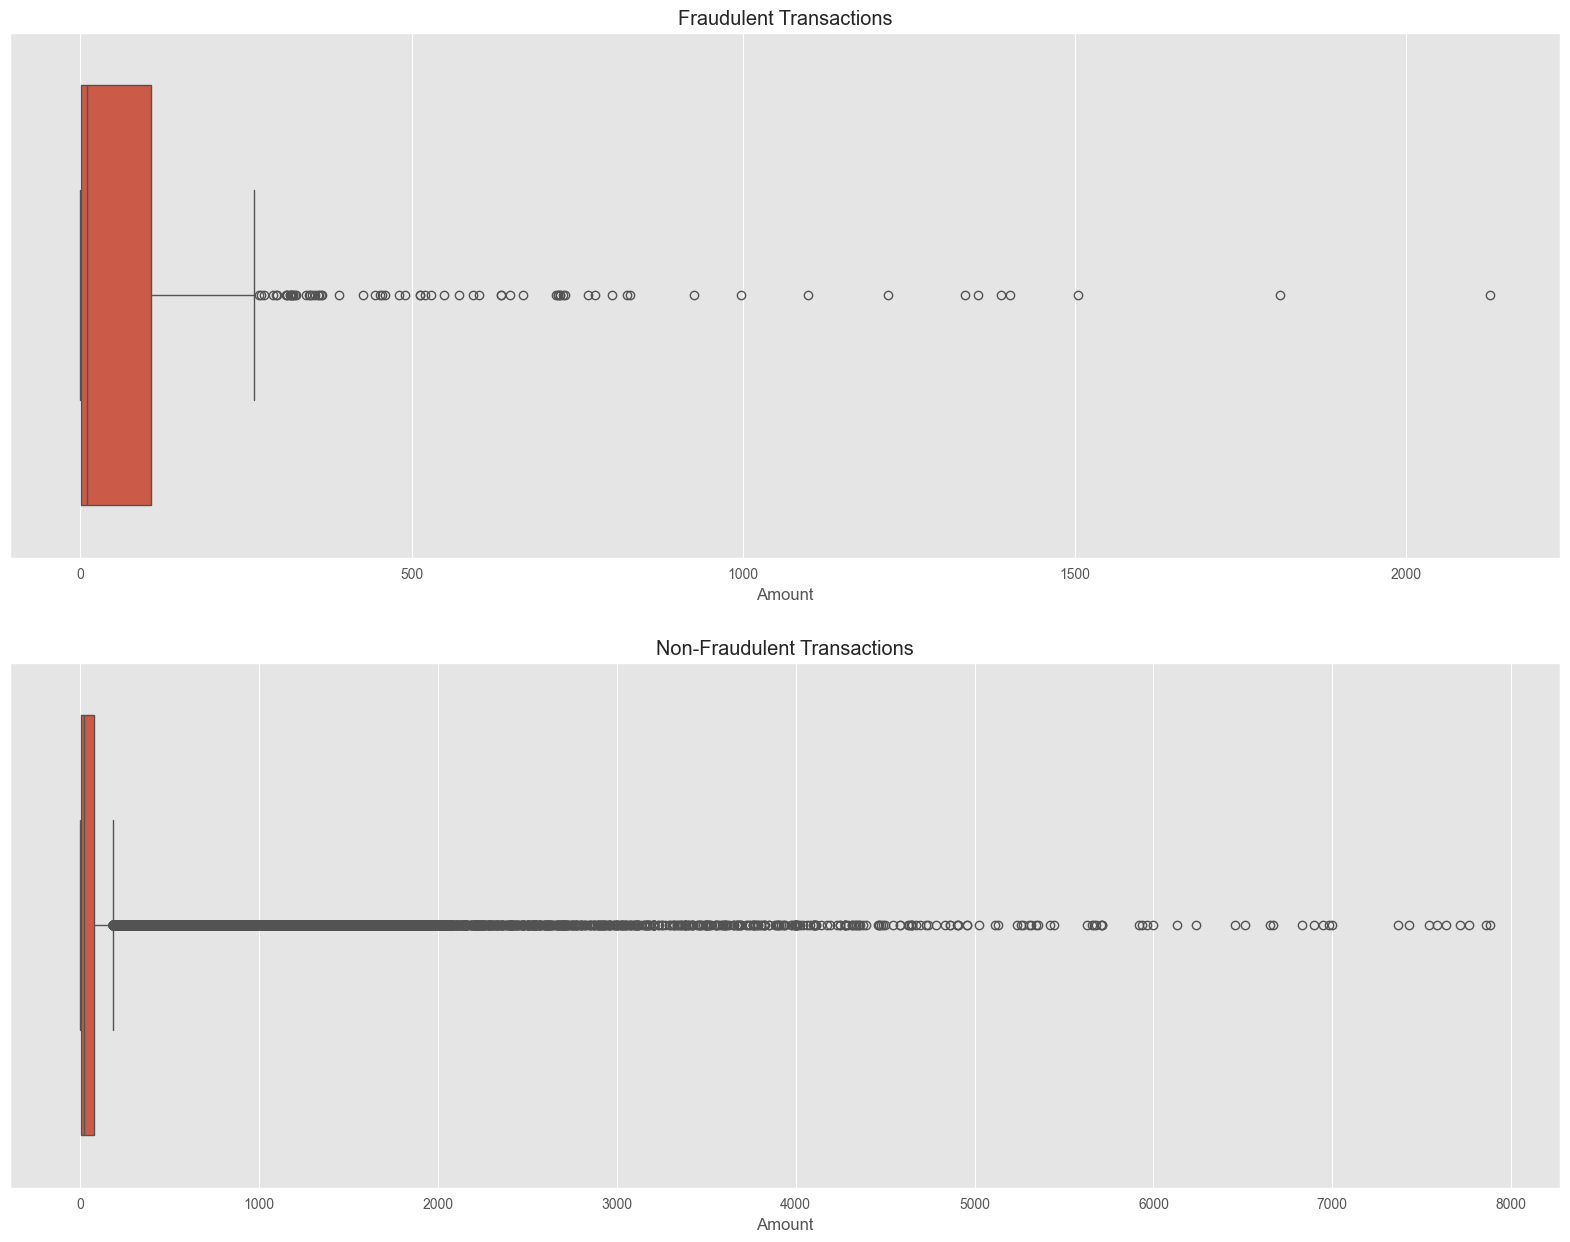

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20, 15))
sns.boxplot(df[df['Class'] == 1].Amount, ax=ax1, orient="h")
ax1.set_title('Fraudulent Transactions')
sns.boxplot(df[df['Class'] == 0].Amount, ax=ax2, orient="h")
ax2.set_title('Non-Fraudulent Transactions')

We can see that the majority of the outliers have been removed while keeping the fraudulent transactions. Now, we will look at a feature correlation heatmap. We can remove or combine redundant features to prevent overfitting, and or speed up training time. It can also help us decide whether to use regularization, trees, etc.

We will use a correlation heat map to visualize the strength of the relationships between the variables.

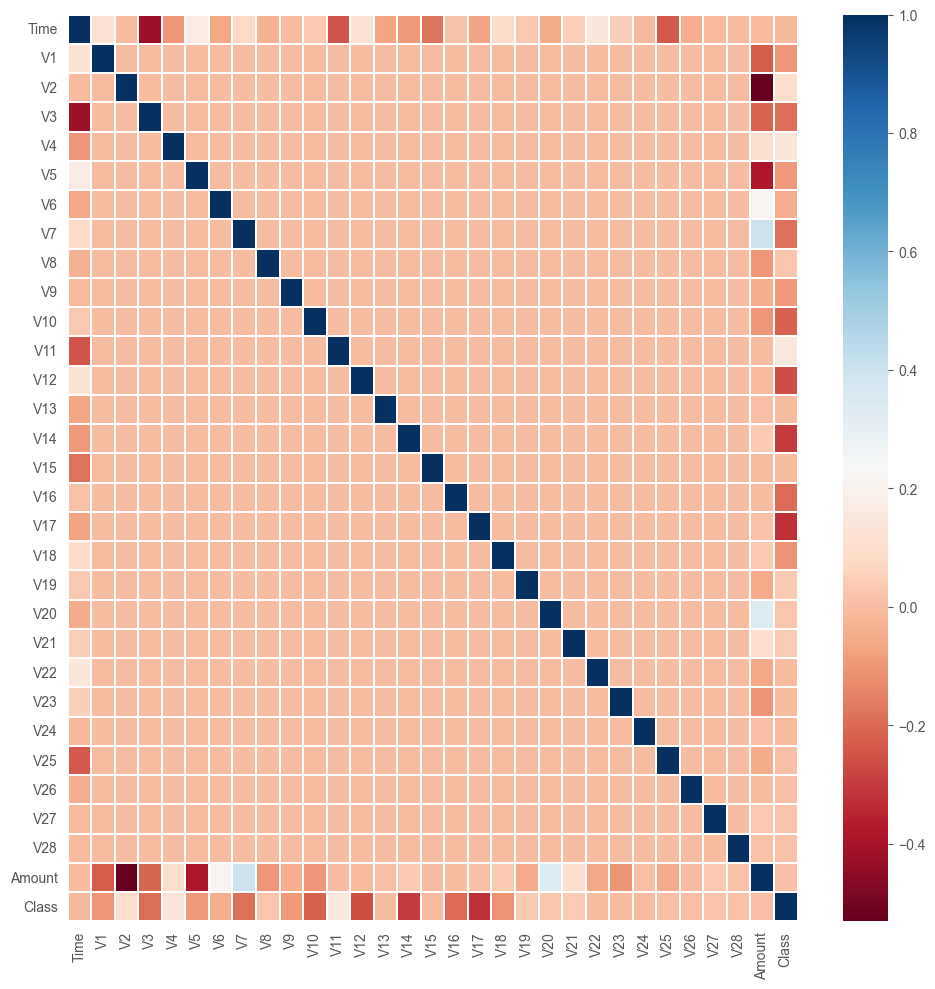

In [21]:
correlation_heatmap = df_copy.corr()
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_heatmap, xticklabels=correlation_heatmap.columns, linewidths=.1, cmap="RdBu", ax=ax)
plt.tight_layout()
plt.show()

It is time to begin preprocessing the data. We are dealing with a highly imbalanced dataset. There are various ways to handle this class imbalance, but we will start with undersampling the majority class. Our approach will consider three options for the minority:majority class ratio. I am choosing: 1:10, 1:20, and 1:50. This will help with mitigating bias in the learning of the model.

In [22]:
print(df["Class"].value_counts())

minority_cnt = df["Class"].value_counts()[1]

ratio_1_to_10 = minority_cnt*10
ratio_1_to_20 = minority_cnt*20
ratio_1_to_50 = minority_cnt*50

non_fraud_transactions_1_to_10 = df[df["Class"] == 0].sample(ratio_1_to_10)
non_fraud_transactions_1_to_20 = df[df["Class"] == 0].sample(ratio_1_to_20)
non_fraud_transactions_1_to_50 = df[df["Class"] == 0].sample(ratio_1_to_50)
fraud = df[df['Class'] == 1]
print(len(non_fraud_transactions_1_to_10), len(non_fraud_transactions_1_to_20), len(non_fraud_transactions_1_to_50), len(fraud))

df_1_to_10 = non_fraud_transactions_1_to_10._append(fraud).sample(frac=1).reset_index(drop=True)
df_1_to_20 = non_fraud_transactions_1_to_20._append(fraud).sample(frac=1).reset_index(drop=True)
df_1_to_50 = non_fraud_transactions_1_to_50._append(fraud).sample(frac=1).reset_index(drop=True)

x_1_to_10 = df_1_to_10.drop(['Class'], axis=1).values
x_1_to_20 = df_1_to_20.drop(['Class'], axis=1).values
x_1_to_50 = df_1_to_50.drop(['Class'], axis=1).values

y_1_to_10 = df_1_to_10['Class'].values
y_1_to_20 = df_1_to_20['Class'].values
y_1_to_50 = df_1_to_50['Class'].values

Class
0    284303
1       492
Name: count, dtype: int64
4920 9840 24600 492


Now, we need to use our random sampled non-fraudulent datasets and combine it with our fraudulent dataset to create 3 training datasets.

In [23]:
tsne_embedding_1_to_10 = TSNE(n_components=2, random_state=24).fit_transform(x_1_to_10)
tsne_embedding_1_to_20 = TSNE(n_components=2, random_state=24).fit_transform(x_1_to_20)
tsne_embedding_1_to_50 = TSNE(n_components=2, random_state=24).fit_transform(x_1_to_50)

We are working with high dimensional data. We want to visualize this data using t-distributed Stochastic Neighbor Embedding (t-SNE). This maps the data points in higher dimensions down to 2-dimensions so that we may see the similarity or differences between the points. Using dimensionality reduction is useful for visualizing clusters and relationships within the data that we have. Unlike Principal Component Analysis (PCA), another form of dimensionality reduction which was done to the data set before we started, it is not a linear method, and we may discover intricate, non-linear relationships in the data. Typically, PCA is performed first to reduce the noise and dimensionality (also speeding up t-SNE), allowing t-SNE to map that data into a 2D (or 3D) space, focussing on the structure of the important components.

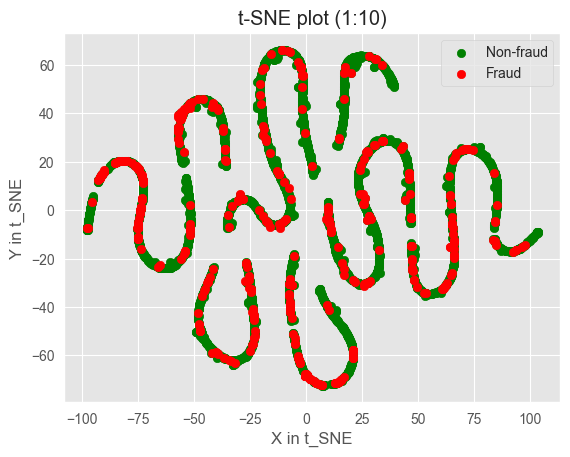

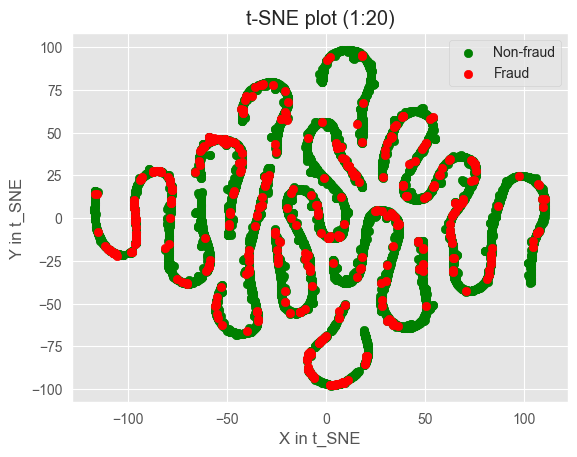

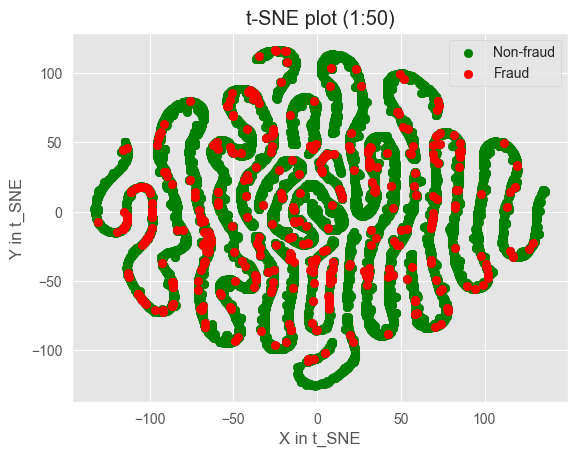

In [24]:
colour_map = {0:'green', 1:'red'}
name_map = {0: "Non-fraud", 1: "Fraud"}

#1:10
plt.figure()
for idx, cl in enumerate(np.unique(y_1_to_10)):
    plt.scatter(x = tsne_embedding_1_to_10[y_1_to_10 == cl,0],
                y = tsne_embedding_1_to_10[y_1_to_10 == cl,1],
                c = colour_map[idx],
                label = name_map[cl])
plt.xlabel('X in t_SNE')
plt.ylabel('Y in t_SNE')
plt.legend(loc = 'upper right')
plt.title('t-SNE plot (1:10)')
plt.show()

#1:20
plt.figure()
for idx, cl in enumerate(np.unique(y_1_to_20)):
    plt.scatter(x = tsne_embedding_1_to_20[y_1_to_20 == cl,0],
                y = tsne_embedding_1_to_20[y_1_to_20 == cl,1],
                c = colour_map[idx],
                label = name_map[cl])
plt.xlabel('X in t_SNE')
plt.ylabel('Y in t_SNE')
plt.legend(loc = 'upper right')
plt.title('t-SNE plot (1:20)')
plt.show()

#1:50
plt.figure()
for idx, cl in enumerate(np.unique(y_1_to_50)):
    plt.scatter(x = tsne_embedding_1_to_50[y_1_to_50 == cl,0],
                y = tsne_embedding_1_to_50[y_1_to_50 == cl,1],
                c = colour_map[idx],
                label = name_map[cl])
plt.xlabel('X in t_SNE')
plt.ylabel('Y in t_SNE')
plt.legend(loc = 'upper right')
plt.title('t-SNE plot (1:50)')
plt.show()

Since there is no separation in the clusters/patterns that we have between the fraudulent and non-fraudulent transactions, we are going to use the hidden representation. This will make the data "human-readable".

We will use and autoencoder as there is a very high volume of "normal" (non-fraudulent) transactions. It will do a good job of "squishing" the data down into lower dimensions. It will eliminate noise, anomaly detection, etc.

The autoencoder has two uses for us. One, it will help us generate a human-readable t-SNE plot, and it will help with our models by balancing complex and imbalanced features.

We will now scale the data so that the model may treat the features more fairly, and will behave in a more stable predictable manner. Autoencoders are sensitive to the input scale, so unscaled data may lead to prolonged training times, and poor local minima, among other things.

### Constructing the Autoencoder.

We need to be careful as to not use the same model for all three datasets. There are two ways to resolve this issue. We can either clone the model and retrain the clones, or we can build three different models. We will choose the latter.

In [25]:
x_scale_1_to_10 = preprocessing.MinMaxScaler().fit_transform(x_1_to_10)
x_scale_1_to_20 = preprocessing.MinMaxScaler().fit_transform(x_1_to_20)
x_scale_1_to_50 = preprocessing.MinMaxScaler().fit_transform(x_1_to_50)

x_norm_1_to_10, x_fraud_1_to_10 = x_scale_1_to_10[y_1_to_10 == 0], x_scale_1_to_10[y_1_to_10 == 1]

x_norm_1_to_20, x_fraud_1_to_20 = x_scale_1_to_20[y_1_to_20 == 0], x_scale_1_to_20[y_1_to_20 == 1]

x_norm_1_to_50, x_fraud_1_to_50 = x_scale_1_to_50[y_1_to_50 == 0], x_scale_1_to_50[y_1_to_50 == 1]

### Training the Autoencoder

In [27]:
def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    model.add(Dense(100, activation='tanh'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(100, activation='tanh'))

    model.add(Dense(input_dim, activation='tanh'))
    model.compile(optimizer='adadelta', loss='mean_squared_error')
    return model

# 1) autoencoder for 1–10
autoEncoder_1_to_10 = build_autoencoder(x_norm_1_to_10.shape[1])

hist_1_to_10 = autoEncoder_1_to_10.fit(
    x_norm_1_to_10, x_norm_1_to_10,
    batch_size=10, epochs=50, shuffle=True, validation_split=0.2
)

# 2) autoencoder for 1–20
autoEncoder_1_to_20 = build_autoencoder(x_norm_1_to_20.shape[1])

hist_1_to_20 = autoEncoder_1_to_20.fit(
    x_norm_1_to_20, x_norm_1_to_20,
    batch_size=10, epochs=50, shuffle=True, validation_split=0.2
)

# 3) autoencoder for 1–50
autoEncoder_1_to_50 = build_autoencoder(x_norm_1_to_50.shape[1])

hist_1_to_50 = autoEncoder_1_to_50.fit(
    x_norm_1_to_50, x_norm_1_to_50,
    batch_size=10, epochs=50, shuffle=True, validation_split=0.2
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4153 - val_loss: 0.3877
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3575 - val_loss: 0.3272
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2951 - val_loss: 0.2627
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2301 - val_loss: 0.1979
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1673 - val_loss: 0.1379
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1129 - val_loss: 0.0900
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0724 - val_loss: 0.0566
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0454 - val_loss: 0.0355
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0291 - val_loss: 0.0233
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0165
Epoch 11/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0147 - val_loss: 0.0128
Epoch 12/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Approximately 30-35 epochs until the validation loss stops decreasing meaningfully and overfitting starts.

In [29]:
encoder_1_to_10 = Sequential(autoEncoder_1_to_10.layers[:2])
encoder_1_to_20 = Sequential(autoEncoder_1_to_20.layers[:2])
encoder_1_to_50 = Sequential(autoEncoder_1_to_50.layers[:2])

After the autoencoder that we built has learnt the representation. The latent representation is the mapping of the transactions in some abstract space. Now, we need to uncover the vectors of that latent space that the autoencoder has learnt.

In [30]:
#hidden representations for non_fraud(norm) and fraud
norm_hidden_representation_1_to_10 = encoder_1_to_10.predict(x_norm_1_to_10)
fraud_hidden_representation_1_to_10 = encoder_1_to_10.predict(x_fraud_1_to_10)

norm_hidden_representation_1_to_20 = encoder_1_to_20.predict(x_norm_1_to_20)
fraud_hidden_representation_1_to_20 = encoder_1_to_20.predict(x_fraud_1_to_20)

norm_hidden_representation_1_to_50 = encoder_1_to_50.predict(x_norm_1_to_50)
fraud_hidden_representation_1_to_50 = encoder_1_to_50.predict(x_fraud_1_to_50)

# 1–10
representation_x_1_to_10 = np.append(
    norm_hidden_representation_1_to_10,
    fraud_hidden_representation_1_to_10,
    axis=0
)
y_norm_1_to_10   = np.zeros(norm_hidden_representation_1_to_10.shape[0])
y_fraud_1_to_10  = np.ones(fraud_hidden_representation_1_to_10.shape[0])
representation_y_1_to_10 = np.append(y_norm_1_to_10, y_fraud_1_to_10)

# 1–20
representation_x_1_to_20 = np.append(
    norm_hidden_representation_1_to_20,
    fraud_hidden_representation_1_to_20,
    axis=0
)
y_norm_1_to_20   = np.zeros(norm_hidden_representation_1_to_20.shape[0])
y_fraud_1_to_20  = np.ones(fraud_hidden_representation_1_to_20.shape[0])
representation_y_1_to_20 = np.append(y_norm_1_to_20, y_fraud_1_to_20)

# 1–50
representation_x_1_to_50 = np.append(
    norm_hidden_representation_1_to_50,
    fraud_hidden_representation_1_to_50,
    axis=0
)
y_norm_1_to_50   = np.zeros(norm_hidden_representation_1_to_50.shape[0])
y_fraud_1_to_50  = np.ones(fraud_hidden_representation_1_to_50.shape[0])
representation_y_1_to_50 = np.append(y_norm_1_to_50, y_fraud_1_to_50)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Let's graph the uncovered vectors with a new t-SNE graph. This is a more human-readable t-SNE mapping. This can show the separation between the two classe.

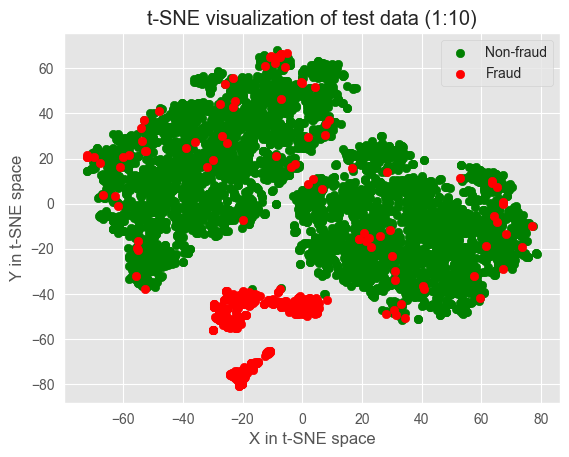

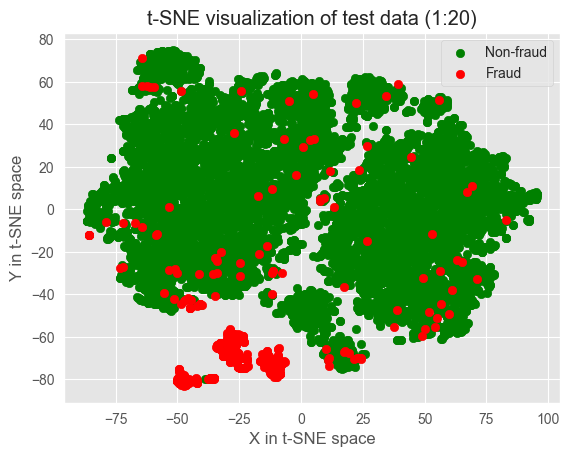

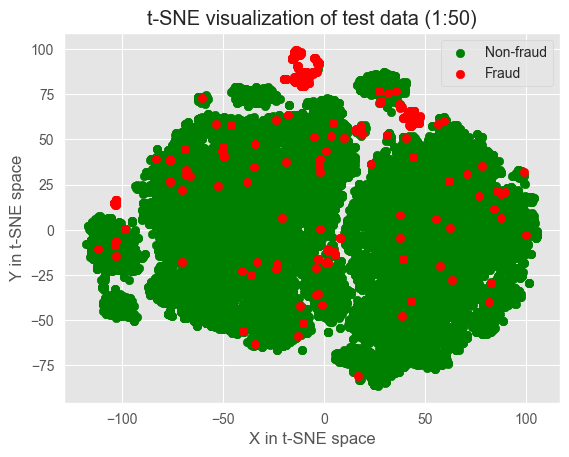

In [31]:
p10 = TSNE(n_components=2, random_state = 24).fit_transform(representation_x_1_to_10)
p20 = TSNE(n_components=2, random_state = 24).fit_transform(representation_x_1_to_20)
p50 = TSNE(n_components=2, random_state = 24).fit_transform(representation_x_1_to_50)

colour_map = {0: 'green', 1: 'red'}
name_map = {0: "Non-fraud", 1: "Fraud"}

plt.figure()
for i, cl in enumerate(np.unique(representation_y_1_to_10)):
    plt.scatter(x = p10[representation_y_1_to_10 == cl, 0],
                y = p10[representation_y_1_to_10 == cl, 1],
                c = colour_map[i],
                label = name_map[cl])
plt.xlabel('X in t-SNE space')
plt.ylabel('Y in t-SNE space')
plt.legend(loc = 'upper right')
plt.title('t-SNE visualization of test data (1:10)')
plt.show()

plt.figure()
for i, cl in enumerate(np.unique(representation_y_1_to_20)):
    plt.scatter(x = p20[representation_y_1_to_20 == cl, 0],
                y = p20[representation_y_1_to_20 == cl, 1],
                c = colour_map[i],
                label = name_map[cl])
plt.xlabel('X in t-SNE space')
plt.ylabel('Y in t-SNE space')
plt.legend(loc = 'upper right')
plt.title('t-SNE visualization of test data (1:20)')
plt.show()

plt.figure()
for i, cl in enumerate(np.unique(representation_y_1_to_50)):
    plt.scatter(x = p50[representation_y_1_to_50 == cl, 0],
                y = p50[representation_y_1_to_50 == cl, 1],
                c = colour_map[i],
                label = name_map[cl])
plt.xlabel('X in t-SNE space')
plt.ylabel('Y in t-SNE space')
plt.legend(loc = 'upper right')
plt.title('t-SNE visualization of test data (1:50)')
plt.show()


To be a thorough as possible, we added many pre-processing steps to make the learning easier and to increase the model's performance. More specifically, our pre-processing steps helped in dealing with: Class Imbalances, Reducing Noise (w/ Representation), Better Separation.

The algorithms that we are going to use are:
- Logistic Regression
    - A great baseline performance. It is a simple model
- Decision Tree
     - Good baseline model
- XGBoost
    - Effective at handling complex data and great at minimizing both false positives and negatives. Precisely what is needed for credit card fraud
- Random Forest
     - Ensemble method with high robustness when dealing with imbalanced datasets.

=== 1:10 ===
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       985
         1.0       1.00      0.71      0.83        98

    accuracy                           0.97      1083
   macro avg       0.99      0.86      0.91      1083
weighted avg       0.97      0.97      0.97      1083



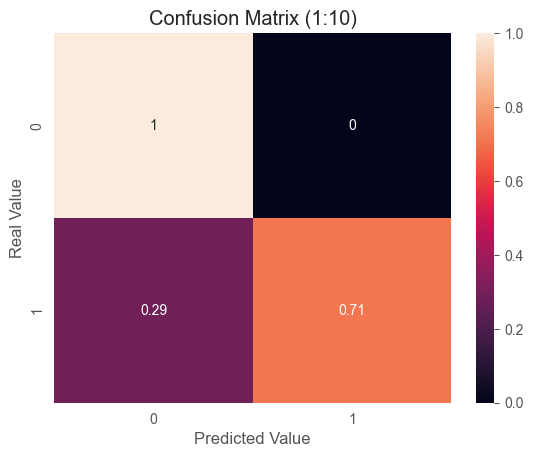

=== 1:20 ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1969
         1.0       0.99      0.67      0.80        98

    accuracy                           0.98      2067
   macro avg       0.98      0.84      0.90      2067
weighted avg       0.98      0.98      0.98      2067



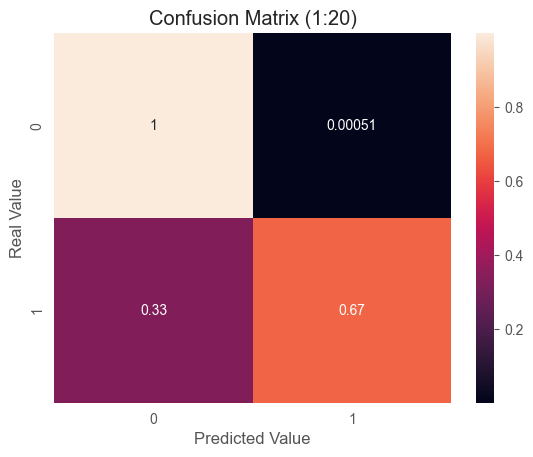

=== 1:50 ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4921
         1.0       0.95      0.62      0.75        98

    accuracy                           0.99      5019
   macro avg       0.97      0.81      0.87      5019
weighted avg       0.99      0.99      0.99      5019



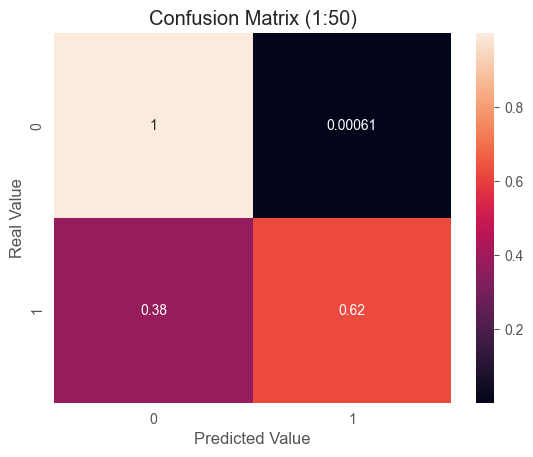

In [37]:
def eval_scale(X, y, title_suffix):
    # train/val split
    train_x, val_x, train_y, val_y = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=24
    )
    # fit logistic regression
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(train_x, train_y)
    pred_y = clf.predict(val_x)

    print(f"=== {title_suffix} ===")
    print(classification_report(val_y, pred_y))

    fig, ax = plt.subplots()
    sns.heatmap(
        confusion_matrix(val_y, pred_y, normalize='true'),
        annot=True, ax=ax
    )
    ax.set_title(f'Confusion Matrix ({title_suffix})')
    ax.set_ylabel('Real Value')
    ax.set_xlabel('Predicted Value')
    plt.show()

# 1–10
eval_scale(representation_x_1_to_10, representation_y_1_to_10, "1:10")

# 1–20
eval_scale(representation_x_1_to_20, representation_y_1_to_20, "1:20")

# 1–50
eval_scale(representation_x_1_to_50, representation_y_1_to_50, "1:50")

=== Decision Tree (1:10) ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       985
         1.0       0.91      0.71      0.80        98

    accuracy                           0.97      1083
   macro avg       0.94      0.85      0.89      1083
weighted avg       0.97      0.97      0.97      1083



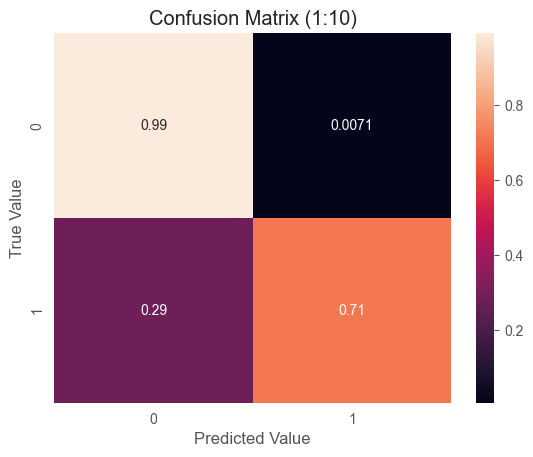

=== Decision Tree (1:20) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1969
         1.0       0.90      0.81      0.85        98

    accuracy                           0.99      2067
   macro avg       0.94      0.90      0.92      2067
weighted avg       0.99      0.99      0.99      2067



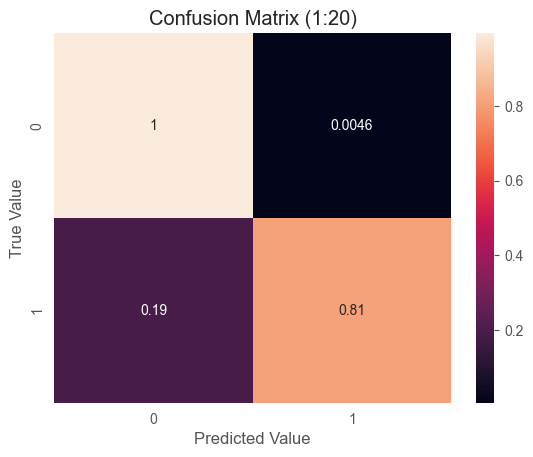

=== Decision Tree (1:50) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4921
         1.0       0.91      0.69      0.79        98

    accuracy                           0.99      5019
   macro avg       0.95      0.85      0.89      5019
weighted avg       0.99      0.99      0.99      5019



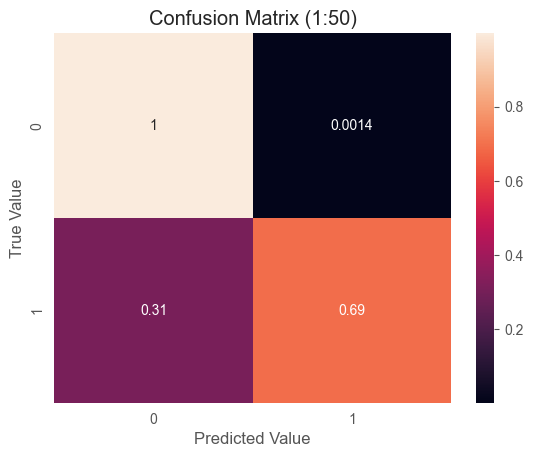

In [33]:
def eval_tree_scale(X, y, title_suffix):
    train_x, val_x, train_y, val_y = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=24
    )

    model = DecisionTreeClassifier(max_depth=6, criterion='entropy', random_state=24)
    model.fit(train_x, train_y)
    y_pred = model.predict(val_x)

    print(f"=== Decision Tree ({title_suffix}) ===")
    print(classification_report(val_y, y_pred))

    fig, ax = plt.subplots()
    sns.heatmap(
        confusion_matrix(val_y, y_pred, normalize='true'),
        annot=True,
        ax=ax
    )
    ax.set_title(f'Confusion Matrix ({title_suffix})')
    ax.set_ylabel('True Value')
    ax.set_xlabel('Predicted Value')
    plt.show()

# 1–10
eval_tree_scale(representation_x_1_to_10, representation_y_1_to_10, "1:10")

# 1–20
eval_tree_scale(representation_x_1_to_20, representation_y_1_to_20, "1:20")

# 1–50
eval_tree_scale(representation_x_1_to_50, representation_y_1_to_50, "1:50")

=== XGBoost (1:10) ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       985
         1.0       0.96      0.80      0.87        98

    accuracy                           0.98      1083
   macro avg       0.97      0.90      0.93      1083
weighted avg       0.98      0.98      0.98      1083



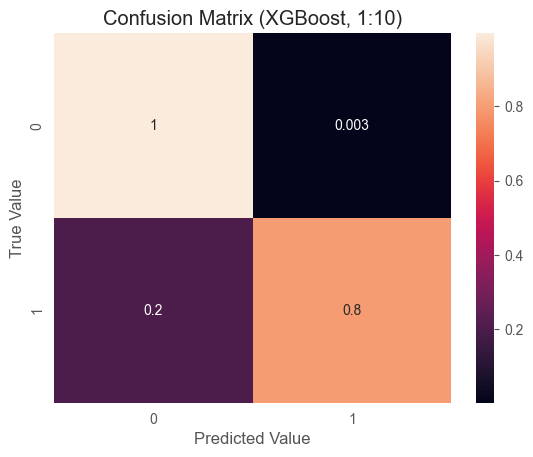

=== XGBoost (1:20) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1969
         1.0       0.98      0.85      0.91        98

    accuracy                           0.99      2067
   macro avg       0.98      0.92      0.95      2067
weighted avg       0.99      0.99      0.99      2067



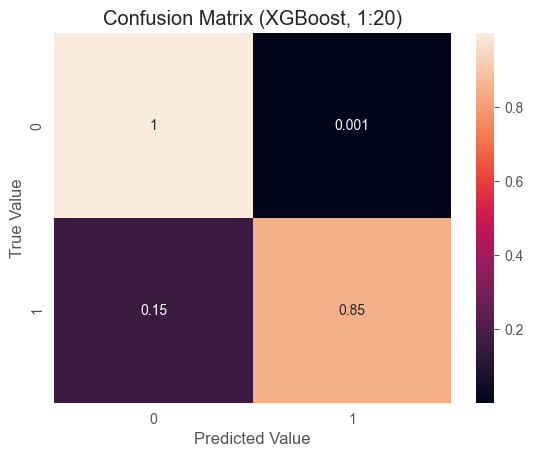

=== XGBoost (1:50) ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4921
         1.0       0.96      0.79      0.87        98

    accuracy                           1.00      5019
   macro avg       0.98      0.89      0.93      5019
weighted avg       1.00      1.00      0.99      5019



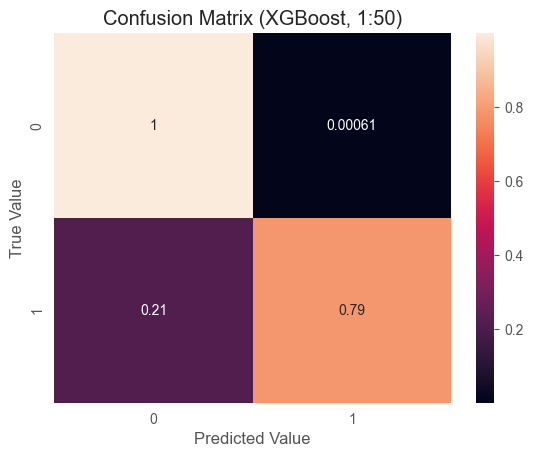

In [34]:
def eval_xgb_scale(X, y, title_suffix):
    train_x, val_x, train_y, val_y = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=24
    )

    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=24,
        n_jobs=-1
    )
    model.fit(train_x, train_y)

    y_pred = model.predict(val_x)

    print(f"=== XGBoost ({title_suffix}) ===")
    print(classification_report(val_y, y_pred))

    fig, ax = plt.subplots()
    sns.heatmap(
        confusion_matrix(val_y, y_pred, normalize='true'),
        annot=True,
        ax=ax
    )
    ax.set_title(f'Confusion Matrix (XGBoost, {title_suffix})')
    ax.set_ylabel('True Value')
    ax.set_xlabel('Predicted Value')
    plt.show()

# 1–10
eval_xgb_scale(representation_x_1_to_10, representation_y_1_to_10, "1:10")

# 1–20
eval_xgb_scale(representation_x_1_to_20, representation_y_1_to_20, "1:20")

# 1–50
eval_xgb_scale(representation_x_1_to_50, representation_y_1_to_50, "1:50")


=== Random Forest (1–10) ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       985
         1.0       0.99      0.80      0.88        98

    accuracy                           0.98      1083
   macro avg       0.98      0.90      0.94      1083
weighted avg       0.98      0.98      0.98      1083



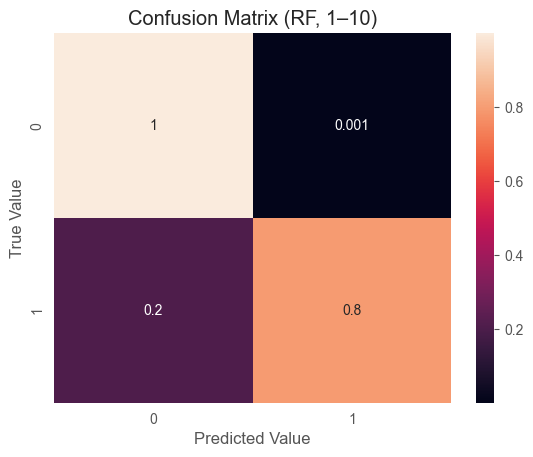

=== Random Forest (1–20) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1969
         1.0       0.99      0.81      0.89        98

    accuracy                           0.99      2067
   macro avg       0.99      0.90      0.94      2067
weighted avg       0.99      0.99      0.99      2067



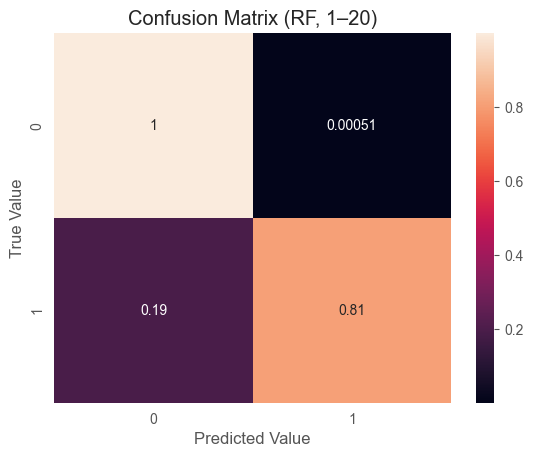

=== Random Forest (1–50) ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4921
         1.0       0.99      0.68      0.81        98

    accuracy                           0.99      5019
   macro avg       0.99      0.84      0.90      5019
weighted avg       0.99      0.99      0.99      5019



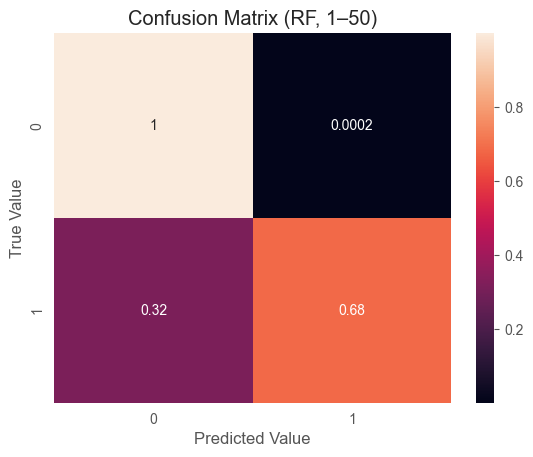

In [41]:
def eval_rf_scale(X, y, title_suffix):
    train_x, val_x, train_y, val_y = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=24
    )

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,        # or a number if you want to regularize
        class_weight='balanced',  # optional, helps with imbalance
        random_state=24,
        n_jobs=-1
    )
    rf.fit(train_x, train_y)
    y_pred = rf.predict(val_x)

    print(f"=== Random Forest ({title_suffix}) ===")
    print(classification_report(val_y, y_pred))

    fig, ax = plt.subplots()
    sns.heatmap(
        confusion_matrix(val_y, y_pred, normalize='true'),
        annot=True,
        ax=ax
    )
    ax.set_title(f'Confusion Matrix (RF, {title_suffix})')
    ax.set_ylabel('True Value')
    ax.set_xlabel('Predicted Value')
    plt.show()

# 1–10
eval_rf_scale(representation_x_1_to_10, representation_y_1_to_10, "1–10")

# 1–20
eval_rf_scale(representation_x_1_to_20, representation_y_1_to_20, "1–20")

# 1–50
eval_rf_scale(representation_x_1_to_50, representation_y_1_to_50, "1–50")